## Setup

In [20]:
import numpy as np
import torch

import torch.multiprocessing as mp

from modelscape.backend.cli import base_args

from modelscape.backend.job_iterator import main as run_job_iterator
from modelscape.backend.utils import ensure_torch
try:
    from mupify import mupify, rescale
    _MUPIFY_AVAILABLE = True
except Exception as _mupify_err:
    mupify = None
    rescale = None
    _MUPIFY_AVAILABLE = False
    _MUPIFY_IMPORT_ERROR = _mupify_err


def _post_init_mupify(model, opt, gamma=1.0, mup_param="mup", **_):
    mupify(model, opt, param=mup_param)
    rescale(model, gamma)
    return model, opt



In [21]:
## All args should be set here

args = base_args() #default args

# Set any args that we want to differ
args.ONLINE = False
args.ONLYTHRESHOLDS = True
args.N_TRAIN=4000
args.N_TEST=1000
args.N_TOT = args.N_TEST+args.N_TRAIN
args.CLASSES = [[0], [6]]
args.NORMALIZED = True
args.NUM_TRIALS = 2
args.LR = 1e-1
args.MAX_ITER = 1e3
args.N_SAMPLES = [8]
args.GAMMA = [0.1, 1, 10]

iterators = [args.N_SAMPLES, range(args.NUM_TRIALS), args.GAMMA]
iterator_names = ["ntrain", "trial", "GAMMA"]

### MLP grab (ex: ENTK)

In [22]:
import torch.nn as nn
def empirical_ntk(model: nn.Module,
                  X_tr: torch.Tensor,
                  create_graph: bool = False, **kwargs) -> torch.Tensor:
    """
    Compute empirical NTK matrix K_ij = <∂θ f(x_i), ∂θ f(x_j)>
    for a scalar-output model.

    Args
    ----
    model : nn.Module
        PyTorch model; output must be scalar per example.
    X : torch.Tensor
        Input data of shape [N, d]. Must require grad on params, not on X.
    create_graph : bool
        If True, keep graph for higher-order derivatives (usually False).

    Returns
    -------
    K : torch.Tensor
        NTK matrix of shape [N, N].
    """
    model.eval()
    device = next(model.parameters()).device
    X = ensure_torch(X_tr)

    # collect parameters we differentiate w.r.t.
    params = [p for p in model.parameters() if p.requires_grad]
    num_params = sum(p.numel() for p in params)

    N = X.shape[0]
    J = torch.zeros(N, num_params, device=device)

    # build Jacobian row-by-row
    offset_slices = []
    start = 0
    for p in params:
        n = p.numel()
        offset_slices.append(slice(start, start + n))
        start += n

    for i in range(N):
        model.zero_grad(set_to_none=True)
        out_i = model(X[i:i+1]).squeeze()  # scalar
        # d out_i / d theta
        grads = torch.autograd.grad(
            out_i,
            params,
            retain_graph=False,
            create_graph=create_graph,
            allow_unused=False
        )
        # flatten and stuff into J[i]
        row = []
        for g in grads:
            row.append(g.reshape(-1))
        J[i] = torch.cat(row, dim=0)

    # NTK = J J^T
    K = J @ J.t()
    return np.asarray(K.cpu())

def empirical_ntk_trace(model: nn.Module,
                  X_tr: torch.Tensor,
                  create_graph: bool = False, **kwargs) -> torch.Tensor:
    return empirical_ntk(model, X_tr, create_graph=create_graph, **kwargs).trace()

## Code execution

In [23]:
## bfn definition
def general_batch_fn(X_total, y_total, X=None, y=None, bsz=128,
                     gen=None, **kwargs):
    def batch_fn(step: int, X=X, y=y):
        if (X is not None) and (y is not None):
            X = ensure_torch(X)
            y = ensure_torch(y)
            return X, y
        with torch.no_grad():
            N_total = X_total.shape[0]
            indices = torch.randint(0, N_total, (bsz,), generator=gen, device=gen.device)
            X_batch = ensure_torch(X_total.to(gen.device)[indices])
            y_batch = ensure_torch(y_total.to(gen.device)[indices])
            return X_batch, y_batch
    return batch_fn

In [24]:
## Dataset setup
from ImageData import ImageData, preprocess
PIXEL_NORMALIZED =  False # Don't normalize pixels, normalize samples
classes = args.CLASSES
normalized = args.NORMALIZED

if classes is not None:
	imdata = ImageData('cifar10', "../data", classes=classes, onehot=len(classes)!=2)
else:
	imdata = ImageData('cifar10', "../data", classes=classes, onehot=False)
X_train, y_train = imdata.get_dataset(args.N_TRAIN, get='train')
X_train = preprocess(X_train, center=True, greyscale=True, normalize=PIXEL_NORMALIZED)
X_test, y_test = imdata.get_dataset(args.N_TEST, get='test')
X_test = preprocess(X_test, center=True, greyscale=True, normalize=PIXEL_NORMALIZED)
X_train, y_train, X_test, y_test = map(ensure_torch, (X_train, y_train, X_test, y_test))
y_train = y_train.squeeze()
y_test = y_test.squeeze()
X_train, y_train, X_test, y_test = [t/torch.linalg.norm(t) for t in (X_train, y_train, X_test, y_test)] if normalized else (X_train, y_train, X_test, y_test)
if normalized:
	X_train *= args.N_TRAIN**(0.5); X_test *= args.N_TEST**(0.5)
	y_train *= args.N_TRAIN**(0.5); y_test *= args.N_TEST**(0.5)
X_full = torch.cat((X_train, X_test), dim=0)
y_full = torch.cat((y_train, y_test), dim=0)
data_eigvals = torch.linalg.svdvals(X_full)**2
data_eigvals /= data_eigvals.sum()

U, lambdas, Vt = torch.linalg.svd(X_full, full_matrices=False)
dim = X_full.shape[1]

bfn_config = dict(base_bfn=general_batch_fn, X_total = X_full, y_total = y_full, bfn_name="general_batch_fn")
del X_full, y_full

Files already downloaded and verified
Files already downloaded and verified


In [25]:
global_config = dict(depth=args.depth, width=args.width, LR=args.LR, GAMMA=args.GAMMA,
	EMA_SMOOTHER=args.EMA_SMOOTHER, MAX_ITER=args.MAX_ITER,
	LOSS_CHECKPOINTS=args.LOSS_CHECKPOINTS, N_TEST=args.N_TEST,
	SEED=args.SEED, ONLYTHRESHOLDS=args.ONLYTHRESHOLDS, DIM=dim,
	ONLINE=args.ONLINE, VERBOSE=args.VERBOSE
	)


if _MUPIFY_AVAILABLE:
    global_config["post_init_fn"] = _post_init_mupify
    global_config["mup_param"] = "mup"

grabs = {'ENTK_trace': empirical_ntk_trace}

global_config.update({"otherreturns": grabs})


In [26]:
# mp.set_start_method("spawn", force=True) #dont use in ipynb

result = run_job_iterator(iterators, iterator_names, global_config, bfn_config=bfn_config)
torch.cuda.empty_cache()

Runs: 100%|██████████| 6/6 [01:38<00:00, 16.47s/it, train 0.466 | test 0.473 | timekey [0 0] | ntrain=8 | trial=1 | GAMMA=10] 


## Analyzing results

In [27]:
result['extras']

{'ENTK_trace': {'var_names': ['ntrain', 'trial', 'GAMMA'],
  'config2outcome': {(8, 0, 0.1): 1.3848659,
   (8, 0, 1): 0.4566541,
   (8, 0, 10): 0.026119053,
   (8, 1, 0.1): 1.3070672,
   (8, 1, 1): 0.44248095,
   (8, 1, 10): 0.027110731},
  'outcome_shape': ()}}

In [28]:
from ExptTrace import ExptTrace
et_losses = ExptTrace.deserialize(result['losses'])
et_entk_trace = ExptTrace.deserialize(result['extras']['ENTK_trace'])

In [29]:
et_entk_trace, et_entk_trace[:, :, :], et_losses[:, :, :]

(<ExptTrace.ExptTrace at 0x7ff3744b4a90>,
 array([[[1.38486588, 0.4566541 , 0.02611905],
         [1.30706716, 0.44248095, 0.02711073]]]),
 array([[[0.85709033, 0.34755889, 0.47636821],
         [0.87069876, 0.33257865, 0.47319874]]]))

Text(0, 0.5, 'Final Loss')

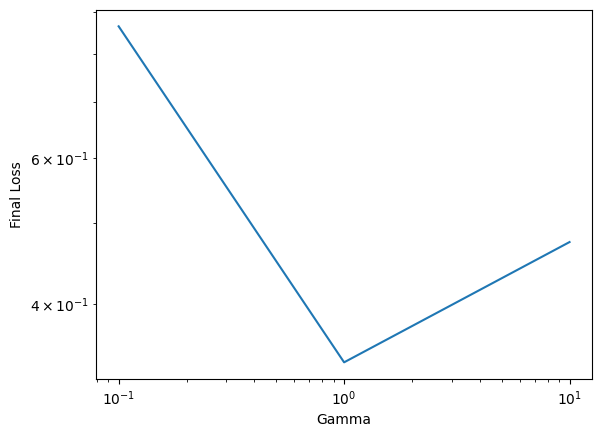

In [30]:
import matplotlib.pyplot as plt
plt.plot(np.unique(np.array(result['jobs'])[:, -1]), et_losses[:, :, :].mean(axis=1).flatten())
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Gamma")
plt.ylabel("Final Loss")